# PROJECT: 
Generate a simulated dataset of $e^+ + e^- \rightarrow \mu^+ + \mu^-$ events.

## Authors:
- Andrea Semenzato
- Pietro Bernardi
- Tomas 
- Mariam

## Supervisor:
- Marco Zanetti

## DESCRIPTION OF THE PROJECT: 
The production of a high brillance muon beam is one of the most important challenge for the future of Particle Physics. A particularly interesting idea consists of shooting high energy positrons on a target, aiming at the production of muons by means of the process $e^+ + e^- \rightarrow \mu^+ + \mu^-$. To mimize the divergence of the resulting "muon beam", the positrons energy is chosen so that the reaction occurs close to threshold (assuming the electrons in the target to be at rest). The main goal of this project is to produce a Monte Carlo simulation of such a process.

In [1]:
# Libraries

import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integrate
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from scipy.stats import uniform
from scipy.stats import chisquare
from scipy.integrate import quad
import math as math
import time
import psutil
import os

1. Compute the process leading-order cross section, $\sigma(\theta; \sqrt{s})$, as a function of the scattering angle $\theta$ and with the  center of mass energy $\sqrt{s}$ as a parameter. Start by computing it in the center of mass system. N.B.: textbooks reports such cross section in the relativistic limit, i.e. for $\sqrt{s}\gg m_\mu$, which is clearly not the case here ($\sqrt{s}\sim 2m_\mu$);

2. Compute and display the angle and momentum components distributions of the emerging muon pairs;

3. Boost muons four-momenta in the laboratory frame, i.e. in the frame where the electron is at rest and the positron has enough energy to give rise to the process;

In [2]:
# Physical costants
electron_charge = 1.602176634e-19 # C
speed_of_light = 299792458 # m/s
alpha = 0.007297
muon_mass = 0.105658374524 #GeV
electron_mass = 0.0005109989461 # GeV
E_exp=2*muon_mass + 0.005

conversion0 = 0.389379e6 #1/GeV --> nanoBarn
conversion1 = (5.34*10**(-19)) #Gev/c ---- > kg*m/s (momentum)
conversion2 = (1.78*10**(-27)) #Gev/c^2 -------> kg (mass)

# Functions
def total_cross_section_nb(s=E_exp**2):
    return (((alpha**2)*np.pi*4/(3*s))*np.sqrt(1-(4*muon_mass**2/s))*(1+(2*muon_mass**2)/s))*conversion0

def differential_cross_section_nb(theta, s=E_exp**2): #rads
    return (((alpha**2)*np.pi*2/(4*s))*np.sqrt(1-(4*muon_mass**2/s))*((1+(4*muon_mass**2/s))+(1-(4*muon_mass**2/s))*np.cos(theta)**2))*conversion0

def pdf_theta(theta, s=E_exp**2): #rads!
    return np.sin(theta)*differential_cross_section_nb(theta, s)

print('Total cross section = ', total_cross_section_nb(E_exp**2))
cost_norm_theta = integrate.quad(lambda theta: pdf_theta(theta),0,np.pi)
print('Normalization pdf = ', cost_norm_theta[0])

def pdf_theta_norm(theta, s=E_exp**2):
    return (1/cost_norm_theta[0])*pdf_theta((theta*np.pi/180), s)*np.pi/180 

print("Verify normalization: ", integrate.quad(lambda theta: pdf_theta_norm(theta),0,180)[0])

E=np.arange(2*muon_mass, E_exp + 0.1,0.0001) #CoM + 0.1 to show high energy behaviour
s=np.power(E,2)
angles=np.arange(0,180,1)
angles_rad=angles*(np.pi/180)
cos_angles=np.cos(angles_rad)

Total cross section =  586.0378845408211
Normalization pdf =  586.0378845408212
Verify normalization:  0.9999999999999999


In [3]:
# Number of iterations
iterations = 8*10**5
# Load parameters for comparison
process = psutil.Process(os.getpid())

4. write a Monte Carlo simulation that generates scattering events following the distrubtions that you found analytically.

## Hit or Miss Monte Carlo Method

The Hit or Miss Monte Carlo method is a technique used for estimating the integral of a function, or more generally, the area under a curve. This method is particularly useful when dealing with complex integrals that are difficult to solve analytically. It relies on stochastic sampling to approximate the value of the integral.

Consider a function $f(x)$ defined over an interval $[a, b]$. The objective is to construct a sample distribution that fills the area beneath the function.

The method involves the following steps:

1. **Enclose the function within a rectangle**: The rectangle has width $(b-a)$ and height $h$, where $h$ is chosen such that it is greater than or equal to the maximum value of $f(x)$ in the interval $[a, b]$.

2. **Randomly sample points within the rectangle**: Generate $N$ random points $(x_i, y_i)$, where $x_i$ is uniformly distributed over $[a, b]$ and $y_i$ is uniformly distributed over $[0, h]$.

3. **Determine hits and misses**: A point $(x_i, y_i)$ is considered a "hit" if $y_i \leq f(x_i)$. Otherwise, it is a "miss".

4. **Assemble the dataset of "hit" points**: Store each "hit" point in an array accessible via a variable, prepared for plotting.

In [4]:
def hit_or_miss(distribution, num_samples, x_range, y_range):
    x_samples = np.random.uniform(*x_range, num_samples)
    y_samples = np.random.uniform(*y_range, num_samples)
    hits = y_samples <= distribution(x_samples)
    return x_samples[hits]

angle_range = (np.min(angles), np.max(angles))  # In degrees
pdf_range = (np.min(pdf_theta_norm(angles)), np.max(pdf_theta_norm(angles)))

mem_before_hm = process.memory_info().rss / 1024 / 1024
start_time_hm = time.time()
theta_samples_hm = hit_or_miss(pdf_theta_norm, iterations, angle_range, pdf_range)
end_time_hm = time.time()
mem_after_hm = process.memory_info().rss / 1024 / 1024
    
time_hm = round((end_time_hm - start_time_hm),3)
mem_usage_hm = round((mem_after_hm - mem_before_hm),3)
accepted_hm = round((len(theta_samples_hm)/iterations),3)

print(f"Execution time: {time_hm} seconds")
print(f"Memory usage: {mem_usage_hm} MB")
print(f"Accepted rate: {accepted_hm}")

Execution time: 0.061 seconds
Memory usage: 5.23 MB
Accepted rate: 0.645


## Importance Sampling Method

Importance Sampling is a variance reduction technique utilized in Monte Carlo simulations for estimating the expected value of a function. This method proves particularly beneficial for functions exhibiting regions of significant variability by aiming to decrease the estimate's variance through more frequent sampling from these critical areas of the function.

The essence of Importance Sampling lies in converting the original expectation problem into a form that exhibits lower variance, thereby enhancing the efficiency of the estimation. Consider a function $f(x)$ defined across a domain $D$. Let $p(x)$ represent a probability density function (PDF) over $D$, from which sampling is feasible. The expected value of $f(x)$ is expressed as:

$$E[f(x)] = \int_D f(x)p(x)dx$$

In instances where direct sampling from $p(x)$ proves inefficient due to the variability of $f(x)$, an alternative PDF, $q(x)$, is employed for sampling. This alternative requires $q(x) > 0$ wherever the product $f(x)p(x) \neq 0$. Consequently, the expected value of $f(x)$ can be reformulated as:

$$E[f(x)] = \int_D \frac{f(x)p(x)}{q(x)}q(x)dx$$

In this equation, $\frac{f(x)p(x)}{q(x)}$ denotes the weighted function, with $q(x)$ serving as the importance sampling distribution.

The methodology encompasses the following steps:

1. **Choose an appropriate importance sampling distribution**: Select a $q(x)$ that mirrors the form of $f(x)p(x)$, yet facilitates easier sampling. The selection of $q(x)$ aims to reduce the variance associated with the weighted function.

2. **Sample points**: Draw samples ${x_i}$ from the distribution $q(x)$.

3. **Compute the weights**: Assign weights to each sampled point according to $w(x_i) = \frac{p(x_i)}{q(x_i)}$. These weights are normalized to ensure they sum to 1, enhancing the representativeness of the sample.

4. **Generate the weighted sample set**: Utilizing the weights computed in step 3, a weighted sample set is constructed by selecting points from the initially sampled distribution. This selection is performed with probability proportional to the computed weights, thereby assembling a dataset reflective of the target distribution's characteristics.

In [5]:
def importance_sampling(iterations, pdf_target_norm, range=(0, 180), proposal_pdf=None):
    theta_samples_prop = np.random.uniform(range[0], range[1], iterations)
    
    if proposal_pdf is None:
        proposal_pdf_values = uniform.pdf(theta_samples_prop, range[0], range[1] - range[0])
    else:
        proposal_pdf_values = proposal_pdf(theta_samples_prop)
    
    weights = np.maximum(pdf_target_norm(theta_samples_prop) / proposal_pdf_values, 0)
    weights /= np.sum(weights)
    
    theta_samples_imp = np.random.choice(theta_samples_prop, size=iterations, p=weights)
    
    return theta_samples_imp

mem_before_imp = process.memory_info().rss / 1024 / 1024
start_time_imp = time.time()
theta_samples_imp = importance_sampling(iterations, pdf_theta_norm)
end_time_imp = time.time()
mem_after_imp = process.memory_info().rss / 1024 / 1024

time_imp = round((end_time_imp - start_time_imp),3)
mem_usage_imp = round((mem_after_imp - mem_before_imp),3)
accepted_imp = round((len(theta_samples_imp)/iterations),3)

print(f"Execution time: {time_imp} seconds")
print(f"Memory usage: {mem_usage_imp} MB")
print(f"Accepted rate: {accepted_imp}")

Execution time: 0.217 seconds
Memory usage: 43.125 MB
Accepted rate: 1.0


## Metropolis-Hastings Algorithm

The Metropolis-Hastings algorithm is a branch of the Markov Chain Monte Carlo (MCMC) methods, designed to generate a sequence of samples from a probability distribution for which direct sampling poses significant challenges. 
By generating a sequence of samples, the Metropolis-Hastings algorithm ensures that, over a large number of samples, the distribution of these samples converges to the target distribution.

The methodology encompasses the following steps:

1. **Initialization**: Start with an initial sample $x_0$, serving as the beginning point of the Markov chain. This sample can be an arbitrary value that falls within the domain of the probability distribution of interest.

2. **Iteration Process**: Each iteration $i$ of the algorithm involves the following steps:
   - A new candidate sample $x'$ is proposed, generated from a normal distribution centered around the current sample with a standard deviation defined by the parameter `passes`. This normal distribution serves as the proposal distribution $q(x'|x_i)$.
   - The acceptance probability $A(x', x_i) = \min\left(1, \frac{p(x')q(x_i|x')}{p(x_i)q(x'|x_i)}\right)$ is calculated, where $p(x)$ represents the value of the target distribution at $x$, and $s$ is a predefined parameter influencing the acceptance ratio. This correctly includes $q(x_i|x')$ and $q(x'|x_i)$ to reflect the proposal distribution's role in the acceptance probability.
   - The candidate $x'$ is accepted with probability $A(x', x_i)$. Upon acceptance, $x_{i+1} = x'$; otherwise, $x_{i+1} = x_i$.
3. **Convergence Criterion**: The iteration continues until the samples adequately represent the target distribution, which may be judged by the total number of iterations or an assessment of the sample distribution's stability over iterations.

In [6]:
def metropolis_hastings(distribution, initial_sample, interations, passes, s=E_exp**2):
    current_sample = initial_sample
    samples = [current_sample]
    accepted = 0
    for i in range(iterations):
        new_sample = np.random.normal(current_sample, passes) #proposal distribution
        acceptance_ratio = distribution(new_sample, s) / distribution(current_sample, s)
        if (np.random.uniform(0,1,1) <= acceptance_ratio):
            current_sample = new_sample
            accepted += 1
        samples.append(current_sample)
    return np.asarray(samples),accepted

initial_sample = 90
passes = 7.5

mem_before_mh = process.memory_info().rss / 1024 / 1024
start_time_mh = time.time()
theta_samples_mh, accepted = metropolis_hastings(pdf_theta_norm, initial_sample, iterations, passes)
end_time_mh = time.time()
mem_after_mh = process.memory_info().rss / 1024 / 1024

time_mh = round((end_time_mh - start_time_mh),3)
mem_usage_mh = round(mem_after_mh - mem_before_mh,3)
accepted_mh = round((len(theta_samples_mh)/iterations),3)

print(f"Execution time: {time_mh} seconds")
print(f"Memory usage: {mem_usage_mh} MB")
print(f"Accepted rate: {accepted_mh}")

Execution time: 9.023 seconds
Memory usage: 2.543 MB
Accepted rate: 1.0


## Inverse Sampling Method

The Inverse Sampling method is utilized for generating random samples from a distribution when direct sampling is complex or infeasible. This method is particularly effective for distributions that are not standard or easily accessible through conventional random number generators.

Inverse Sampling transforms uniformly distributed random numbers into samples from a target distribution by utilizing the inverse of the Cumulative Distribution Function (CDF) of the target distribution. This transformation hinges on the principle that if a random variable $Y$ is uniformly distributed, then the variable $X = F^{-1}(Y)$ follows the distribution $F$, where $F$ is the CDF of the target distribution.

The provided `inverse_sampling` function demonstrates this method through several steps:

1. **Define the Target PDF**: A probability density function (PDF) for $\cos(\theta)$, relevant to particle physics distributions, is defined. This function, `pdf_cos`, calculates the density based on parameters such as the angle $\theta$, the alpha constant, the muon mass, and a normalization factor to ensure the PDF integrates to 1 over its domain.

2. **Normalize the PDF**: The PDF is normalized over its domain to ensure that its total integral equals 1, creating a valid probability density function, `pdf_cos_norm`.

3. **Compute the Inverse of the CDF**: Instead of directly computing the CDF and then its inverse, the `inverse_sampling` function employs the `brentq` method to find zeros of the function `cdf_zeros`—effectively solving for $x$ in the equation $F(x) = y$ where $y$ is a uniformly distributed random number. This approach utilize the CDF's properties indirectly to generate samples corresponding to the target distribution.

4. **Generate Uniform Samples and Transform**: Uniform random samples are generated, representing $y$ values. Each uniform sample is transformed into a sample from the target distribution by finding the corresponding $\theta$ value that satisfies the inverse CDF equation through the `cdf_zeros` function.

In [7]:
def inverse_sampling(iterations):
    def pdf_cos(z, s=E_exp**2):
        return (((alpha**2) * np.pi * 2 / (4 * s)) * np.sqrt(1 - (4 * muon_mass**2 / s)) *
                ((1 + (4 * muon_mass**2 / s)) + (1 - (4 * muon_mass**2 / s)) * z**2)) * 0.389379e6

    cost_norm_cos = integrate.quad(lambda z: pdf_cos(z), -1, 1)[0]

    def pdf_cos_norm(z, s=E_exp**2):
        return pdf_cos(z, s) / cost_norm_cos

    def cdf_zeros(y, x, s=E_exp**2):
        cost = ((alpha**2) * np.pi * 2 / (4 * s)) * np.sqrt(1 - (4 * muon_mass**2 / s)) * conversion0
        norm_cost = total_cross_section_nb(s)
        return (-cost / norm_cost) * (1/3 * (1 - (4 * muon_mass**2 / s)) *
                                      y**3 + (1 + (4 * muon_mass**2 / s)) * y - 4/3 * (1 + 2 * muon_mass**2 / s)) - x

    r_samples = np.random.uniform(0, 1, iterations)
    theta_samples_is = [brentq(cdf_zeros, -1, 1, args=(r,)) for r in r_samples]

    return theta_samples_is

mem_before_is = process.memory_info().rss / 1024 / 1024
start_time_is = time.time()
theta_samples_is = inverse_sampling(iterations)
end_time_is = time.time()
mem_after_is = process.memory_info().rss / 1024 / 1024

time_is = round((end_time_is - start_time_is),3)
mem_usage_is = round((mem_after_is - mem_before_is),3)
accepted_is = round((len(theta_samples_is)/iterations),3)
theta_samples_isc = 180*np.arccos(theta_samples_is)/np.pi

print(f"Execution time: {time_is} seconds")
print(f"Memory usage: {mem_usage_is} MB")
print(f"Accepted rate: {accepted_is}")

Execution time: 21.64 seconds
Memory usage: 22.125 MB
Accepted rate: 1.0


## Sequential Monte Carlo Method

The Sequential Monte Carlo (SMC) method, also known as particle filtering, is used for approximating posterior distributions. This method is especially useful in situations where the target distribution evolves over time or is otherwise difficult to sample from directly due to its complexity.

SMC works by maintaining a set of samples, often referred to as "particles," which represent the posterior distribution of interest. These particles are propagated through time (or iterations) using two main steps: resampling based on weights derived from the target distribution, and moving the particles via a proposal distribution. This process adjusts the density of particles to more closely resemble the target distribution over iterations.

The `sequential_monte_carlo` function illustrates a basic SMC algorithm through several steps:

1. **Initial Sampling**: Initially, particles (samples) $\theta$ are drawn uniformly from the proposal range.

2. **Iteration and Weighting**: For a given number of steps, the particles are weighted according to their likelihood under the target distribution `pdf_target_norm`. These weights represent the relevance of each particle in approximating the target distribution.

3. **Normalization of Weights**: The weights are normalized to ensure they sum to 1, allowing them to be used for the next step.

4. **Resampling**: Based on the calculated weights, a resampling step is performed where particles are probabilistically selected to form the next generation of samples. This selection process favors particles with higher weights, thus steering the ensemble towards regions of higher probability under the target distribution.

In [8]:
def sequential_monte_carlo(iterations, pdf_target_norm, steps=1):
    theta_samples_se = np.random.uniform(0, 180, iterations)
    
    for step in range(steps):
        weights = pdf_target_norm(theta_samples_se)
        weights /= np.sum(weights)
        theta_samples_se = np.random.choice(theta_samples_se, size=iterations, p=weights)
    
    return theta_samples_se

mem_before_se = process.memory_info().rss / 1024 / 1024
start_time_se = time.time()
theta_samples_se = sequential_monte_carlo(iterations, pdf_theta_norm, steps=1)
end_time_se = time.time()
mem_after_se = process.memory_info().rss / 1024 / 1024

time_se = round((end_time_se - start_time_se),3)
mem_usage_se = round((mem_after_se - mem_before_se),3)
accepted_se = round((len(theta_samples_se)/iterations),3)

print(f"Execution time: {time_se} seconds")
print(f"Memory usage: {mem_usage_se} MB")
print(f"Accepted rate: {accepted_se}")

Execution time: 0.195 seconds
Memory usage: 24.312 MB
Accepted rate: 1.0


## Stratified Sampling Method

Stratified Sampling is a method used in Monte Carlo simulations to improve the accuracy and efficiency of estimations by dividing the population into distinct subgroups, or strata, and sampling from each stratum separately.

The `stratified_sampling` function implements stratified sampling with the following steps:

1. **Domain Partitioning**: The domain, described by a range, is divided into `strata` number of equal intervals. Each interval represents a stratum from which samples are drawn.

2. **Stratum-Specific Sampling**:
    - For each stratum, the integral of the target probability density function (PDF), `pdf_target_norm`, over the stratum's range is computed. This integral represents the stratum's contribution to the total integral over the entire domain.
    - Based on this contribution, a proportionate number of samples, `stratum_samples_count`, is determined for each stratum. This ensures that strata with higher values contribute more samples, aligning the sampling process with the distribution's density.

3. **Sample Generation**: Within each stratum, `stratum_samples_count` samples are generated uniformly. These samples are then aggregated to form the final set of samples, `theta_samples_st`.

4. **Normalization and Aggregation**: The samples from all strata are combined to create a comprehensive sample set that reflects the overall distribution's characteristics more accurately than simple random sampling.

In [9]:
def stratified_sampling(iterations, pdf_target_norm, range_start=0, range_end=180, strata=10):
    
    theta_samples_st = np.array([])
    total_integral = integrate.quad(pdf_target_norm, range_start, range_end)[0]

    for stratum in range(strata):
        stratum_start = range_start + (range_end - range_start) * (stratum / strata)
        stratum_end = range_start + (range_end - range_start) * ((stratum + 1) / strata)
        
        stratum_integral = integrate.quad(pdf_target_norm, stratum_start, stratum_end)[0]
        
        stratum_samples_count = int((stratum_integral / total_integral) * iterations)
        
        if stratum_samples_count > 0:
            stratum_samples = np.random.uniform(stratum_start, stratum_end, stratum_samples_count)
            theta_samples_st = np.concatenate((theta_samples_st, stratum_samples))

    return theta_samples_st
    
strata = 100

mem_before_st = process.memory_info().rss / 1024 / 1024
start_time_st = time.time()
theta_samples_st = stratified_sampling(iterations, pdf_theta_norm, strata=strata)
end_time_st = time.time()
mem_after_st = process.memory_info().rss / 1024 / 1024

time_st = round((end_time_st - start_time_st),3)
mem_usage_st = round((mem_after_st - mem_before_st),3)
accepted_st = round((len(theta_samples_st)/iterations),3)

print(f"Execution time: {time_st} seconds")
print(f"Memory usage: {mem_usage_st} MB")
print(f"Accepted rate: {accepted_st}")

Execution time: 0.031 seconds
Memory usage: 0.0 MB
Accepted rate: 1.0


### PLOTTING

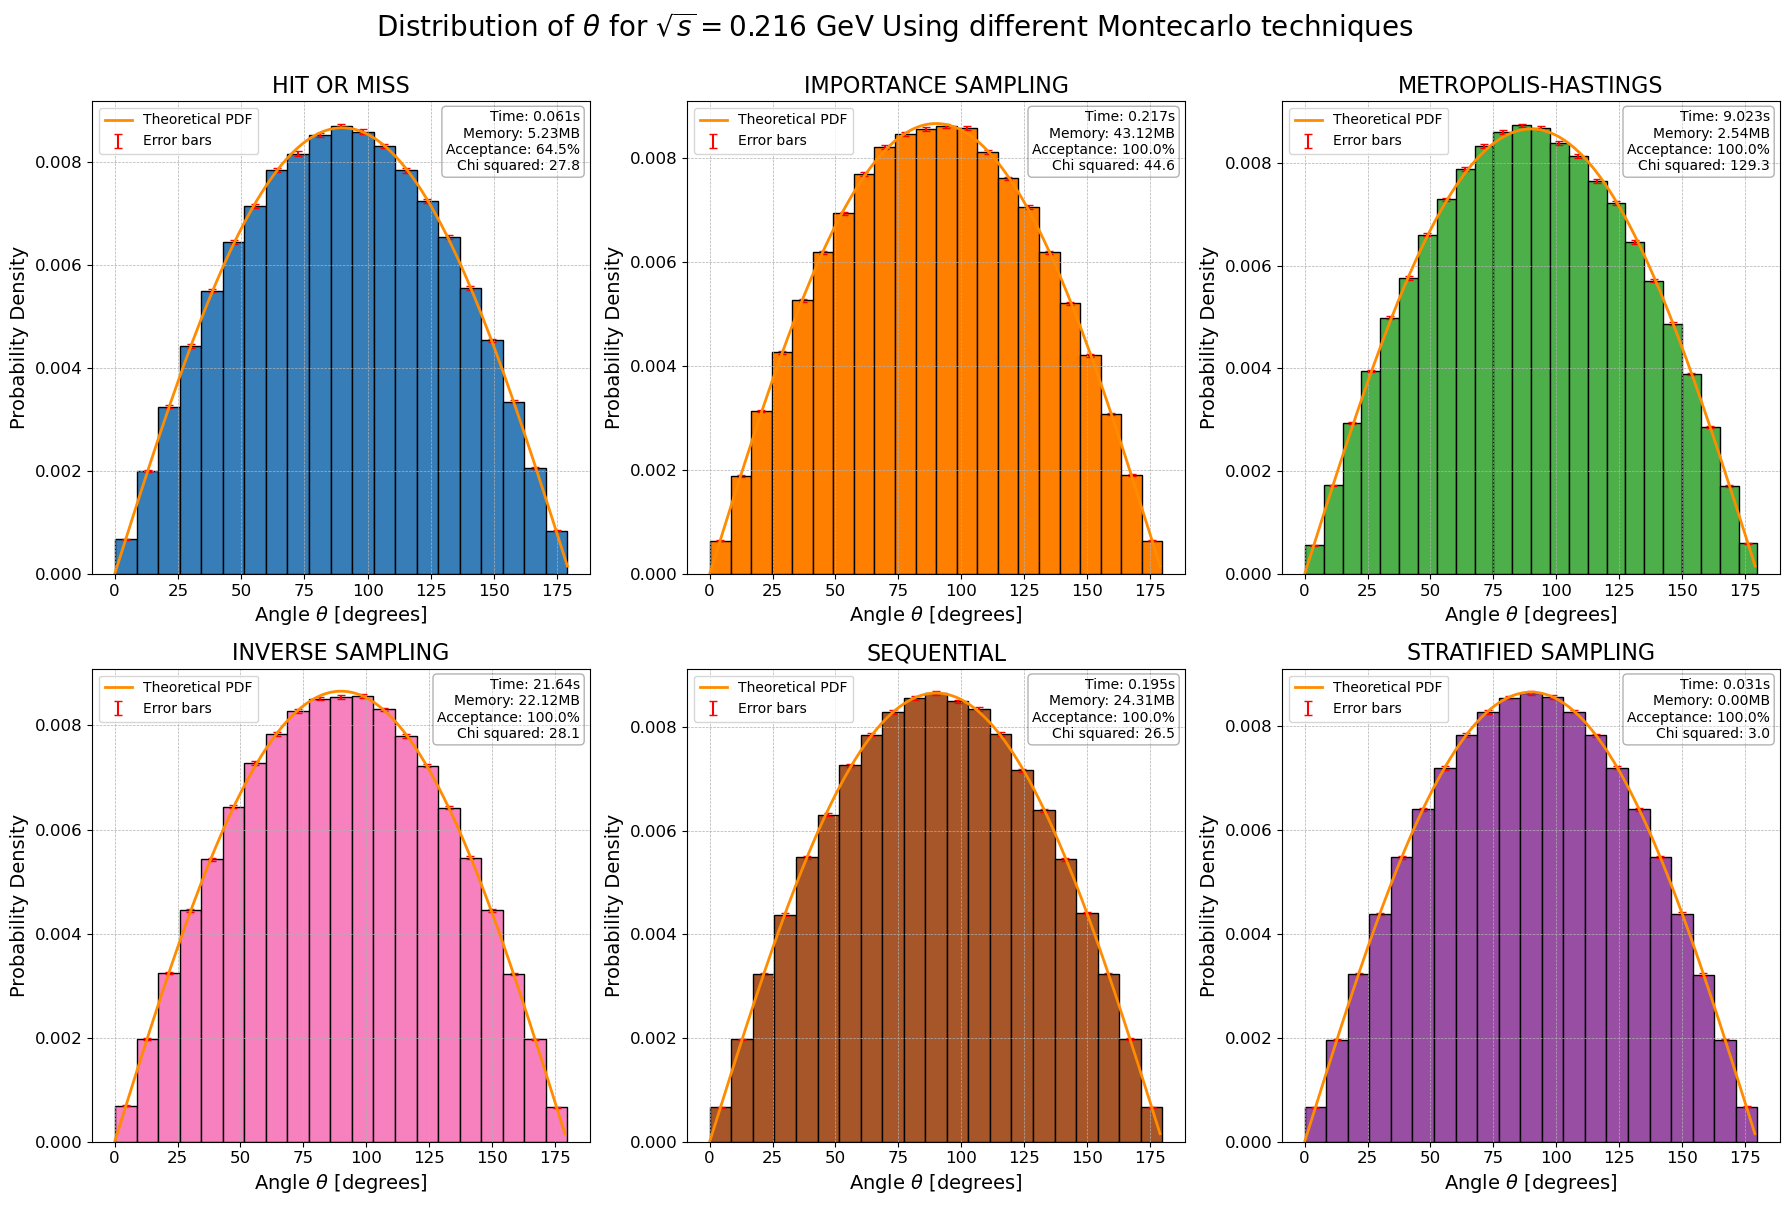

In [10]:
names = ["HIT OR MISS","IMPORTANCE SAMPLING","METROPOLIS-HASTINGS","INVERSE SAMPLING","SEQUENTIAL","STRATIFIED SAMPLING"]
methods = ["hm","imp","mh","isc","se","st"]
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3']
times = [time_hm, time_imp, time_mh, time_is, time_se, time_st]
mem_usages = [mem_usage_hm, mem_usage_imp, mem_usage_mh, mem_usage_is, mem_usage_se, mem_usage_st]
acceptances = [accepted_hm, accepted_imp, accepted_mh, accepted_is, accepted_se, accepted_st]
chis = []


for method in methods:
    dataset = globals()[f'theta_samples_{method}']
    observed_counts, bins = np.histogram(dataset, bins='doane', density=False)
    bin_widths = np.diff(bins)
    expected_probs = np.array([quad(pdf_theta_norm, bins[i], bins[i+1])[0] for i in range(len(bins)-1)])
    expected_counts = expected_probs / sum(expected_probs) * sum(observed_counts)
    chi_squared_stat = chisquare(f_obs=observed_counts, f_exp=expected_counts)
    chis.append(chi_squared_stat.statistic)

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (method, time, mem_usage, acceptance, chi) in enumerate(zip(methods, times, mem_usages, acceptances, chis)):
    dataset = globals()[f'theta_samples_{method}']
    
    counts, bins, patches = axs[i].hist(dataset, bins="doane", density=True, color=colors[i], edgecolor='black')
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_width = np.diff(bins)
    total_samples = len(dataset)
    errors = np.sqrt(counts / (total_samples * bin_width))
    axs[i].errorbar(bin_centers, counts, yerr=errors, fmt='none', ecolor='r', capsize=3, label='Error bars')
    
    axs[i].plot(angles, pdf_theta_norm(angles), color='darkorange', linewidth=2, label="Theoretical PDF")
    axs[i].set_title(names[i], fontsize=16)
    axs[i].set_xlabel(r'Angle $\theta$ [degrees]', fontsize=14)
    axs[i].set_ylabel('Probability Density', fontsize=14)
    axs[i].legend(loc='upper left', fontsize=10)
    axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[i].tick_params(axis='both', which='major', labelsize=12)

    info_text = f"Time: {time}s\nMemory: {mem_usage:.2f}MB\nAcceptance: {acceptance*100:.1f}%\nChi squared: {chi:.1f}"
    axs[i].text(0.98, 0.98, info_text, transform=axs[i].transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.3, boxstyle="round,pad=0.3"))

fig.suptitle(r'Distribution of $\theta$ for $\sqrt{s}=$' + str(round(E_exp, 3)) + ' GeV Using different Montecarlo techniques',
             fontsize=20, y=1.0)
plt.tight_layout()
plt.show()

### BABAYAGA COMPARISON

BabaYaga is a Monte Carlo event generator designed for $e^+e^-$ collisions into $e^+e^-$, $\mu^+\mu^-$, $\gamma\gamma$, and $\pi^+\pi^-$ at energies below 10-12 GeV, developed by C.M. Carloni Calame, G. Montagna, O. Nicrosini, and F. Piccinini at INFN Pavia. More information can be found on its [official webpage](https://www2.pv.infn.it/~hepcomplex/babayaga.html).

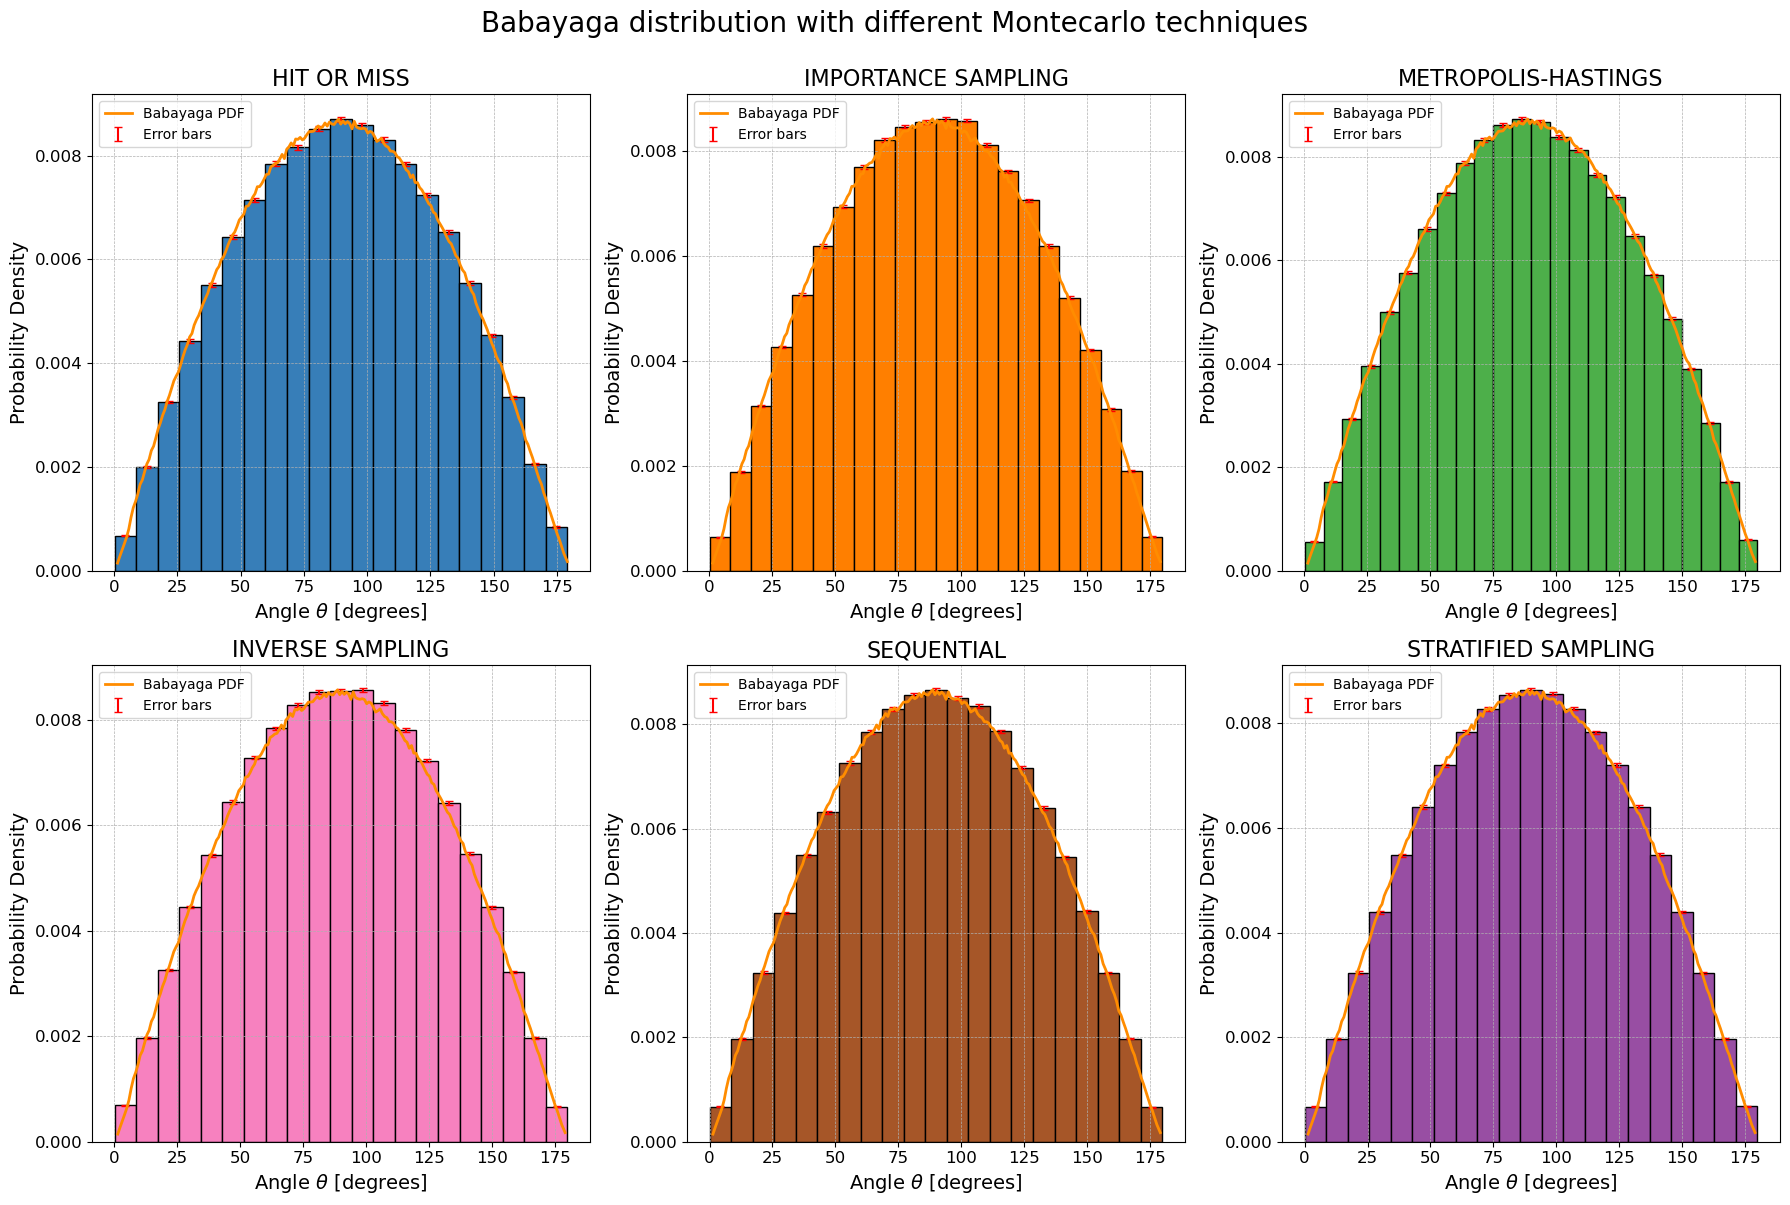

In [11]:
Babayaga = np.loadtxt("matched_el_th_exp_200.txt").T

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

for i, (method, time, mem_usage, acceptance) in enumerate(zip(methods, times, mem_usages, acceptances)):
    dataset = globals()[f'theta_samples_{method}']
    
    counts, bins, patches = axs[i].hist(dataset, bins="doane", density=True, color=colors[i], edgecolor='black')

    k = (np.max(Babayaga[1])) / np.max(counts)
    baba_plotted = Babayaga[1] / k
    centers = [Babayaga[0][i] + (Babayaga[0][i+1] - Babayaga[0][i]) / 2 for i in np.arange(0, len(Babayaga[0]) - 1)]
    centers.append(Babayaga[0][-1] + (Babayaga[0][-1] - Babayaga[0][-2]))
    
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_width = np.diff(bins)
    total_samples = len(dataset)
    errors = np.sqrt(counts / (total_samples * bin_width))
    axs[i].errorbar(bin_centers, counts, yerr=errors, fmt='none', ecolor='r', capsize=3, label='Error bars')
    
    axs[i].plot(centers, baba_plotted, color='darkorange', linewidth=2, label="Babayaga PDF")
    axs[i].set_title(names[i], fontsize=16)
    axs[i].set_xlabel(r'Angle $\theta$ [degrees]', fontsize=14)
    axs[i].set_ylabel('Probability Density', fontsize=14)
    axs[i].legend(loc='upper left', fontsize=10)
    axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[i].tick_params(axis='both', which='major', labelsize=12)

fig.suptitle(r'Babayaga distribution with different Montecarlo techniques',
             fontsize=20, y=1.0)
plt.tight_layout()
plt.show()

5. produce a synthetic dataset of about $N=10^5$ (or more) events. Events should be listed as rows in a file with columns representing the muons coordinates (keep in mind that in the lab frame muons are relativistic and thus the number of coordinates can be only 3 per muon).

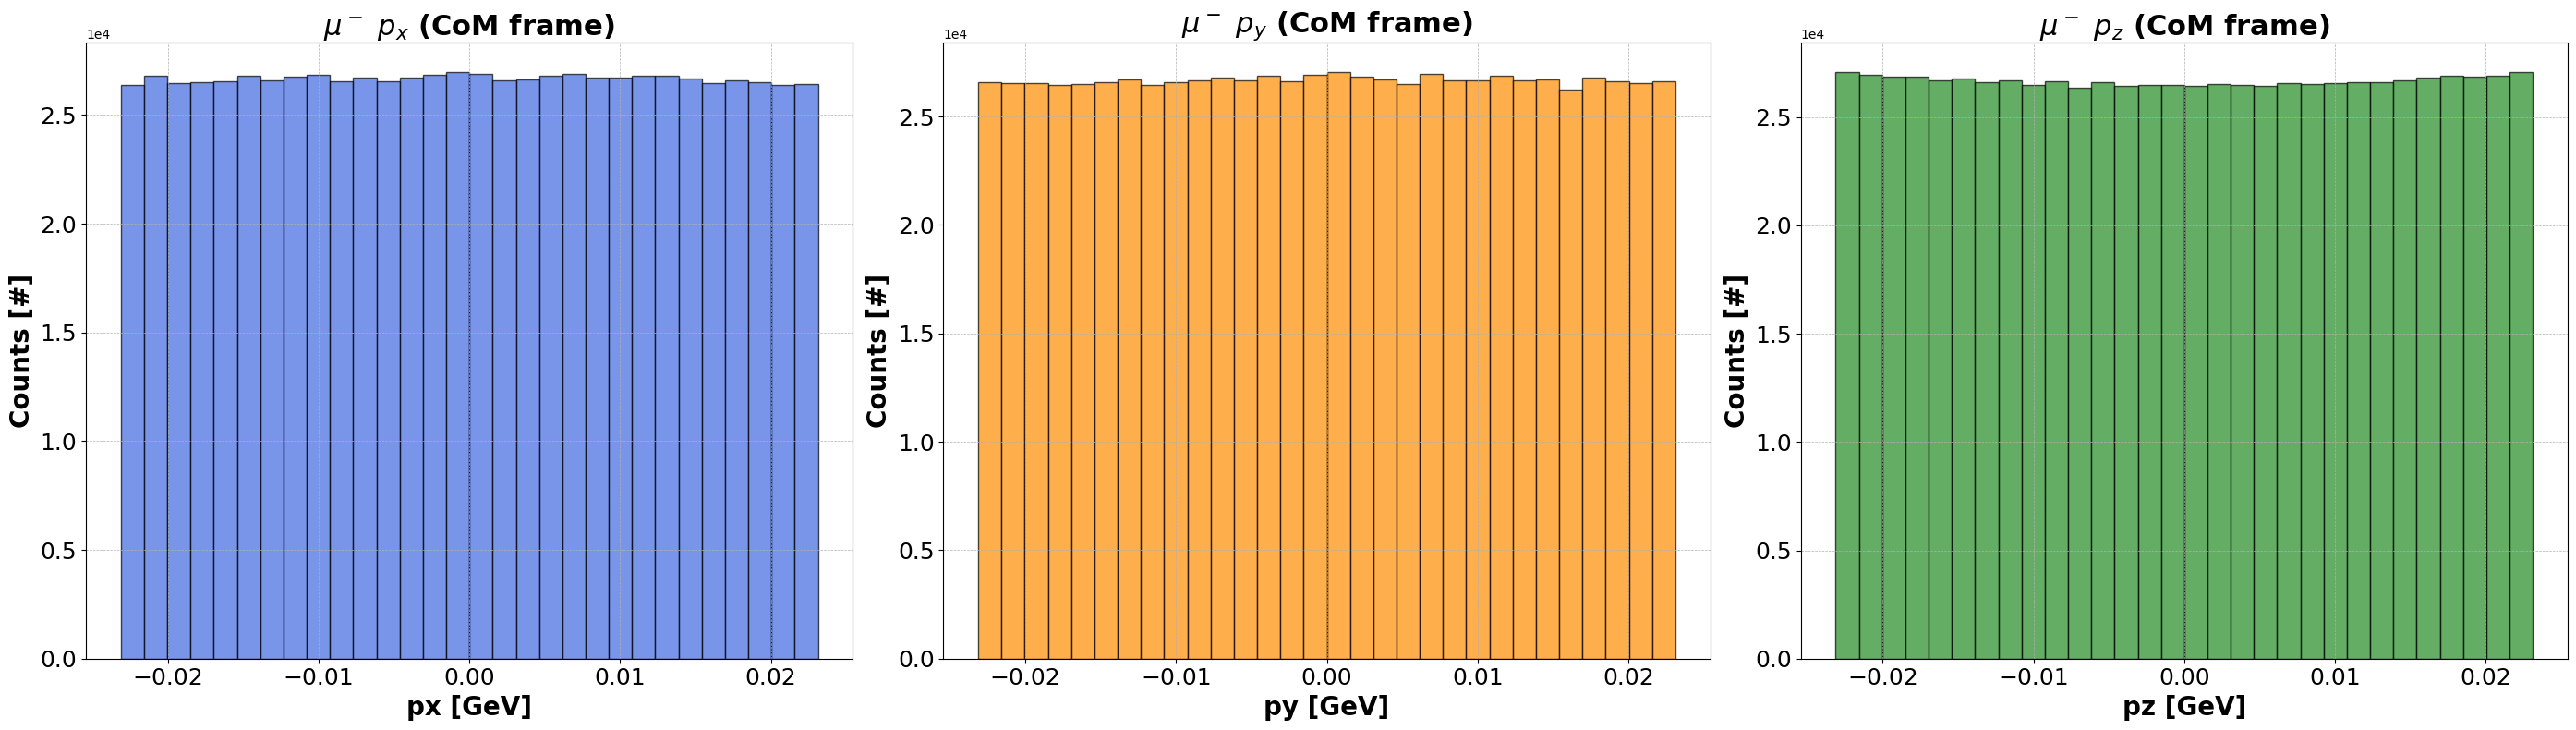

   Anti_muon_px  Anti_muon_py  Anti_muon_pz   Muon_px   Muon_py   Muon_pz
0     -0.000110      0.000495      0.023115  0.000110 -0.000495 -0.023115
1     -0.000149     -0.000005      0.023120  0.000149  0.000005 -0.023120
2     -0.000118      0.000274      0.023118  0.000118 -0.000274 -0.023118
3      0.000584     -0.000193      0.023112 -0.000584  0.000193 -0.023112
4      0.000390      0.000230      0.023116 -0.000390 -0.000230 -0.023116


In [13]:
%precision 6

N_samples = len(theta_samples_st)
phi = 360 * np.random.rand(N_samples)
momentum = np.sqrt(E_exp**2 / 4 - muon_mass**2)

sin_theta = np.sin(np.radians(theta_samples_st))
cos_theta = np.cos(np.radians(theta_samples_st))
sin_phi = np.sin(np.radians(phi))
cos_phi = np.cos(np.radians(phi))

momenta = pd.DataFrame({
    'Anti_muon_px': momentum * cos_phi * sin_theta,
    'Anti_muon_py': momentum * sin_phi * sin_theta,
    'Anti_muon_pz': momentum * cos_theta,
})

momenta[['Muon_px', 'Muon_py', 'Muon_pz']] = -momenta[['Anti_muon_px', 'Anti_muon_py', 'Anti_muon_pz']]
momenta.to_csv("Momenta_CoM.csv", index=False, index_label=False)

fig, axs = plt.subplots(1, 3, figsize=(28, 8))
titles = [r'$\mu^-$ $p_x$ (CoM frame)', r'$\mu^-$ $p_y$ (CoM frame)', r'$\mu^-$ $p_z$ (CoM frame)']
components = ['Muon_px', 'Muon_py', 'Muon_pz']
colors = ['royalblue', 'darkorange', 'forestgreen']

for i, (component, title, color) in enumerate(zip(components, titles, colors)):
    axs[i].hist(momenta[component], bins=30, color=color, edgecolor='black', alpha=0.7)
    axs[i].set_title(title, fontsize=22, fontweight='bold')
    axs[i].set_xlabel(f'{component[-2:]} [GeV]', fontsize=20, fontweight='bold')
    axs[i].set_ylabel("Counts [#]", fontsize=20, fontweight='bold')
    axs[i].tick_params(labelsize=18)
    axs[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[i].grid(which='major', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

print(momenta.head())

6. assume a $3$ cm thick Beryllium block is used as target and a rate of positron on target of $10^6$ Hz. Compute the rescaling factor (weight) you need to apply to the $N$ simulated events such that they represent the statistics that would be gathered in a week of countinuous operations.

7. repeat what done so far simulating now the actual transverse shape and energy spread of the beam: for the former assume a flat distribution in a circle of radius $r=1$ cm and for the latter a gaussian distribution centered at the nominal beam energy and a width of $0.5$ GeV.

8. given that the electrons traversing the target lose energy as $E(z)=E_0 \exp{-z/X_0}$ (with z the longitudinal coordinate of the target, the one parallel to the beam direction and $X_0$ is the Beryllium radiation length), compute the nominal beam energy $E_0$ such that muon pairs can be generated along the whole length of the target.